This notebook implements concepts from the [Multi-Objective Loss Balancing for Physics-Informed Deep Learning paper](https://arxiv.org/abs/2110.09813). It highlights the gains in performance when applying Loss Balancing Schemes to PINN training.

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.autograd import grad

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [2]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, g=100.0, alpha=0.999, temperature=1., rho=0.9999):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        g : float, optional
            Interaction strength (default is 100.0).
        alpha, optional : float
                Controls the exponential weight decay rate.
                Value between 0 and 1. The smaller, the more stochasticity.
                0 means no historical information is transmitted to the next iteration.
                1 means only first calculation is retained. Defaults to 0.999.
        temperature, optional : float
                Softmax temperature coefficient. Controlls the "sharpness" of the softmax operation.
                Defaults to 1.
        rho, optional : float
                Probability of the Bernoulli random variable controlling the frequency of random lookbacks.
                Value berween 0 and 1. The smaller, the fewer lookbacks happen.
                0 means lambdas are always calculated w.r.t. the initial loss values.
                1 means lambdas are always calculated w.r.t. the loss values in the previous training iteration.
                Defaults to 0.9999.
        """
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.g = g  # Interaction strength
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed

        self.alpha = alpha
        self.temperature = temperature
        self.rho = rho
        self.call_count = 0  # Track the number of forward calls

        # Initialize dynamic weights and loss history
        self.lambdas = [1.0] * 5  # For boundary, PDE, riesz, symmetry, and normalization losses
        self.last_losses = [1.0] * 5
        self.init_losses = [1.0] * 5

    def build_network(self):
        """
        Build the neural network with sine activation functions between layers.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model representing the neural network architecture.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def forward(self, inputs):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor containing spatial points (collocation points).

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution.
        """
        return self.network(inputs)

    def compute_potential(self, x, potential_type="gaussian", a=0.5, l=1.0):
        """
        Compute a symmetric potential function for the 1D domain.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates.
        potential_type : str, optional
            Type of potential ('gaussian' or 'sine'), by default "gaussian".
        a : float, optional
            Center of the potential (for Gaussian), by default 0.5.
        l : float, optional
            Length scale for sine potential, by default 1.0.

        Returns
        -------
        V : torch.Tensor
            Tensor of symmetric potential values at the input points.

        Raises
        ------
        ValueError
            If the potential type is not recognized.
        """
        # Gaussian potential centered at `a`
        if potential_type == "gaussian":
            V = torch.exp(-(x - a) ** 2)
        # Sine potential symmetric about the center of the domain
        else:
            V = torch.sin(torch.pi * (x - (a - l / 2)) / l)

        return V

    def boundary_loss(self, boundary_points, boundary_values):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(boundary_points)
        return torch.mean((u_pred - boundary_values) ** 2)

    def riesz_loss(self, predictions, inputs, eta):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        eta : float
            Interaction strength.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """
        u = predictions

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        u_x = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                  grad_outputs=torch.ones_like(predictions),
                                  create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.mean(u_x ** 2)  # Kinetic term
        V = self.compute_potential(inputs)
        potential_term = torch.mean(V * u ** 2)  # Potential term
        interaction_term = 0.5 * eta * torch.mean(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)

        return riesz_energy

    def pde_loss(self, inputs, predictions, eta):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        predictions : torch.Tensor
            Predicted solution from the network.
        eta : float
            Interaction strength.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        u = predictions

        # Compute first and second derivatives with respect to x
        u_x = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Compute λ from the energy functional
        V = self.compute_potential(inputs)
        lambda_pde = torch.mean(u_x ** 2 + V * u ** 2 + eta * u ** 4) / torch.mean(u ** 2)

        # Residual of the 1D Gross-Pitaevskii equation
        pde_residual = -u_xx + V * u + eta * torch.abs(u ** 2) * u - lambda_pde * u

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        L_drive = torch.exp(-lambda_pde + 1.0)

        # PDE loss (residual plus regularization terms)
        pde_loss = torch.mean(pde_residual ** 2)  # + L_lambda + L_f

        return pde_loss, pde_residual, lambda_pde

    def symmetry_loss(self, collocation_points, lb, ub):
        """
        Compute the symmetry loss to enforce u(x) = u(1-x).

        Parameters
        ----------
        collocation_points : torch.Tensor
            Tensor of interior spatial points.
        lb : torch.Tensor
            Lower bound of interval.
        ub: torch.Tensor
            Upper bound of interval.

        Returns
        -------
        sym_loss : torch.Tensor
            The mean squared error enforcing symmetry u(x) = u(1-x).
        """
        # Reflect points across the center of the domain
        x_reflected = (lb + ub) - collocation_points

        # Predict u(x) and u(1-x) using the model
        u_original = self.forward(collocation_points)
        u_reflected = self.forward(x_reflected)

        # Compute mean squared difference to enforce symmetry
        sym_loss = torch.mean((u_original - u_reflected) ** 2)

        return sym_loss

    def total_loss(self, collocation_points, boundary_points, boundary_values, eta, lb, ub):
        """
        Compute the total loss combining boundary loss, Riesz energy loss,
        PDE loss, L^2 norm regularization loss, and symmetry loss.

        Parameters
        ----------
        collocation_points : torch.Tensor
            Input tensor of spatial coordinates for the interior points.
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        eta : float
            Interaction strength.
        lb : torch.Tensor
            Lower bound of interval.
        ub : torch.Tensor
            Upper bound of interval.

        Returns
        -------
        total_loss : torch.Tensor
            Total loss value.
        """

        # Compute individual loss components
        data_loss = self.boundary_loss(boundary_points, boundary_values)
        riesz_energy = self.riesz_loss(self.forward(collocation_points), collocation_points, eta)
        pde_loss, _, _ = self.pde_loss(collocation_points, self.forward(collocation_points), eta)
        norm_loss = (torch.norm(self.forward(collocation_points), p=2) - 1) ** 2

        # Symmetry loss for collocation and boundary points
        #sym_loss_collocation = self.symmetry_loss(collocation_points)
        #sym_loss_boundary = self.symmetry_loss(boundary_points)
        #sym_loss = (sym_loss_collocation + sym_loss_boundary) / 2
        sym_loss = self.symmetry_loss(collocation_points, lb, ub)


        # Collect losses in a list
        losses = [data_loss, riesz_energy, pde_loss, norm_loss, sym_loss]

        # Define manual weights for each term (adjust as needed)
        manual_weights = [500.0, 1.0, 2.0, 100.0, 500]

        # Initialize lambdas and histories
        if self.call_count == 0:
            num_terms = len(losses)
            self.lambdas = [1.0] * num_terms
            self.last_losses = [loss.item() for loss in losses]
            self.init_losses = [loss.item() for loss in losses]

        # Compute lambdas_hat (relative to the last losses)
        lambdas_hat = [
            losses[i].item() / (self.last_losses[i] * self.temperature + 1e-8) for i in range(len(losses))
        ]
        lambdas_hat = torch.softmax(torch.tensor(lambdas_hat) - max(lambdas_hat), dim=0).tolist()

        # Compute init_lambdas_hat (relative to the initial losses)
        init_lambdas_hat = [
            losses[i].item() / (self.init_losses[i] * self.temperature + 1e-8) for i in range(len(losses))
        ]
        init_lambdas_hat = torch.softmax(torch.tensor(init_lambdas_hat) - max(init_lambdas_hat), dim=0).tolist()

        # Random lookbacks controlled by rho
        rho = torch.bernoulli(torch.tensor(self.rho))
        alpha = self.alpha if self.call_count > 1 else (0.0 if self.call_count == 1 else 1.0)

        # Update lambdas
        self.lambdas = [
            float(rho * alpha * self.lambdas[i] +
                  (1 - rho) * alpha * init_lambdas_hat[i] +
                  (1 - alpha) * lambdas_hat[i])
            for i in range(len(losses))
        ]

        # Update loss history
        self.last_losses = [loss.item() for loss in losses]

        # Apply manual weights to the dynamically computed lambdas
        weighted_lambdas = [lambda_i * weight for lambda_i, weight in zip(self.lambdas, manual_weights)]

        # Compute total loss
        total_loss = sum(lambda_i * loss for lambda_i, loss in zip(weighted_lambdas, losses))
        self.call_count += 1

        return total_loss, data_loss, riesz_energy, pde_loss, norm_loss

# Initialize Weights

In [3]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [4]:
def prepare_training_data(N_u, N_f, lb, ub):
    """
    Prepare boundary and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points.
    lb : np.ndarray
        Lower bounds of the domain.
    ub : np.ndarray
        Upper bounds of the domain.

    Returns
    -------
    collocation_points : np.ndarray
        Collocation points.
    boundary_points : np.ndarray
        Boundary points.
    boundary_values : np.ndarray
        Boundary values.
    """

    # Boundary of interval
    boundary_points = np.array([[lb], [ub]])
    boundary_values = np.zeros((2, 1))

    # Dynamically sample points inside the interval
    collocation_points = np.random.rand(N_f, 1) * (ub - lb) + lb

    return collocation_points, boundary_points, boundary_values

# Train PINN

In [5]:
def train_pinn(X, N_u, N_f, layers, eta, epochs, lb, ub, model_save_path):
    """
    Train the Physics-Informed Neural Network (PINN) for the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    X : np.ndarray
        Input data for the neural network
    N_u : int
        Number of boundary points
    N_f : int
        Number of collocation points (interior points) for the physics-based loss
    layers : list of int
        Architecture of the neural network
    eta : float
        Interaction strength
    epochs: int
        Number of epochs
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    model_save_path : str
        Save path for trained model

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained model
    loss_history : list
        List of loss values recorded during training
    """
    # Instantiate the PINN model and initialize its weights
    model = GrossPitaevskiiPINN(layers).to(device)
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, factor=0.5, verbose=True)

    # Prepare training data (collocation and boundary points)
    collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

    # Convert data to PyTorch tensors and move to device
    collocation_points_tensor = torch.tensor(collocation_points, dtype=torch.float32, requires_grad=True).to(device)
    boundary_points_tensor = torch.tensor(boundary_points, dtype=torch.float32).to(device)
    boundary_values_tensor = torch.tensor(boundary_values, dtype=torch.float32).to(device)
    lb_tensor = torch.tensor(lb, dtype=torch.float32).to(device)
    ub_tensor = torch.tensor(ub, dtype=torch.float32).to(device)

    loss_history = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss (boundary, Riesz energy, PDE, normalization, and symmetry losses)
        loss, data_loss, riesz_energy, pde_loss, norm_loss = model.total_loss(collocation_points_tensor, boundary_points_tensor, boundary_values_tensor, eta, lb_tensor, ub_tensor)

        # Backpropagation and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()

        # Scheduler step (for ReduceLROnPlateau)
        scheduler.step(loss)

        # Record the total loss every 100 epochs
        if epoch % 100 == 0:
            loss_history.append(loss.item())

        # Record the pde loss and lambda every 10000 epochs
        if epoch % 10000 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}')
            pde_loss, _, lambda_pde = model.pde_loss(collocation_points_tensor, model.forward(collocation_points_tensor), eta)

    return model, loss_history

# Normalize Wave Function


In [6]:
def normalize_wave_function(u):
    """
    Normalize the wave function with respect to its maximum value.

    Parameters
    ----------
    u : torch.Tensor
        The predicted wave function.

    Returns
    -------
    torch.Tensor
        The normalized wave function.
    """
    return np.abs(u) / np.max(np.abs(u))

# Plot Potential

In [7]:
def plot_potential_1D(X_test, potential):
    """
    Plot the 1D potential function.

    Parameters
    ----------
    X_test : np.ndarray
        The test points where the potential is computed.
    potential : np.ndarray
        The computed potential values at the test points.
    """
    plt.figure(figsize=(6, 5))

    # X_test is the x-values (positions) of the 1D potential
    plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    plt.title('Potential $V(x)$ in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$V(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Train and Save PINN

In [8]:
def train_and_save_pinn(X, N_u, N_f, layers, eta, epochs, lb, ub, model_save_path):
    """
    Train the Physics-Informed Neural Network (PINN) model and save it.

    This function trains a PINN model for the 1D Gross-Pitaevskii equation with a specific interaction
    strength (eta) and saves the trained model to a specified path. It also returns the trained model
    and the loss history recorded during training.

    Parameters
    ----------
    X : np.ndarray
        Input data for the training (e.g., spatial domain points).
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points (interior points) for physics-based loss.
    layers : list of int
        Architecture of the neural network, defined as a list of layer sizes.
        For example, [1, 100, 100, 100, 1] represents an input layer with 1 neuron,
        three hidden layers with 20 neurons each, and an output layer with 1 neuron.
    eta : float
        Interaction strength parameter for the Gross-Pitaevskii equation.
    epochs : int
        Number of training epochs.
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    model_save_path : str
        File name to save the trained model weights (e.g., 'model_eta_1.pth').

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    loss_history : list of float
        A list of loss values recorded during training for each epoch
    """
    model = GrossPitaevskiiPINN(layers).to(device)
    model.apply(initialize_weights)

    # Train the model
    model, loss_history = train_pinn(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta, epochs=epochs, lb=lb, ub=ub, model_save_path=model_save_path)

    # Directory to save the models
    model_save_dir = 'models'
    os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save model after training
    save_model_path = os.path.join(model_save_dir, model_save_path)
    torch.save(model.state_dict(), save_model_path)  # Save model weights

    return model, loss_history

# Predict and Plot

In [9]:
def predict_and_plot(models, etas, X_test, save_path='plots/predicted_solutions.png'):
    """
    Predict and plot the solutions for all models and save the plot.

    Parameters
    ----------
    models : list of models
        A list of trained models.
    etas : list of float
        A list of eta values corresponding to each model.
    X_test : np.ndarray
        Test points along the 1D interval.
    save_path : str, optional
        The path to save the plot image (default is 'plots/predicted_solutions.png').

    Returns
    -------
    None
    """
    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))
    for model, eta in zip(models, etas):
        model.eval()  # Set the model to evaluation mode

        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        u_pred = model(X_test_tensor).detach().cpu().numpy()
        u_pred_normalized = normalize_wave_function(u_pred)
        plt.plot(X_test, u_pred_normalized, label=f'Predicted Solution ($\\eta$ ≈ {eta})')

    plt.title('Ground State Solution by PINN (Riesz Method)', fontsize="xx-large")
    plt.xlabel('x', fontsize="xx-large")
    plt.ylabel('u(x)', fontsize="xx-large")
    plt.grid(True)
    plt.legend(fontsize="large")

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot Loss History

In [10]:
def plot_loss_history(loss_histories, etas, save_path='plots/loss_history.png'):
    """
    Plot the training loss history for different values of eta and save the plot.

    Parameters
    ----------
    loss_histories : list of lists
        A list where each element is a list of loss values recorded during training
        for a specific eta.
    etas : list of float
        A list of eta values corresponding to each loss history.
    save_path : str, optional
        The path to save the plot image (default is 'plots/loss_history.png').

    Returns
    -------
    None
    """
    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))
    for loss_history, eta in zip(loss_histories, etas):
        plt.plot(loss_history, label=f'Loss ($\\eta$ ≈ {eta})')

    plt.xlabel('Training step (x 100)', fontsize="xx-large")
    plt.ylabel('Total Loss', fontsize="xx-large")
    plt.yscale('log')
    plt.title('Loss History for Different Interaction Strengths ($\\eta$)', fontsize="xx-large")
    plt.legend(fontsize="large")
    plt.grid(True)

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Main

In [11]:
# Parameters
N_u = 100  # Number of boundary points
N_f = 2000  # Number of collocation points
epochs = 20001 # Number of iterations of training
layers = [1, 50, 50, 50, 1]  # Neural network architecture
lb, ub = -10, 10  # Boundary limits
X = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Input grid for training

# Test points
X_test = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Test points for prediction
etas = [1, 10, 100, 1000]  # Interaction strengths

# Train and save models and loss history for different interaction strengths
models = []
loss_histories = []
for eta in etas:
    model_save_path = f"trained_model_eta_{eta}.pth"
    model, loss_history = train_and_save_pinn(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta, epochs=epochs, lb=lb, ub=ub, model_save_path=model_save_path)
    models.append(model)
    loss_histories.append(loss_history)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/20001], Loss: 56403.925781
Epoch [10000/20001], Loss: 0.000093
Epoch [20000/20001], Loss: 0.000096
Epoch [0/20001], Loss: 1022.125549
Epoch [10000/20001], Loss: 0.085294
Epoch [20000/20001], Loss: 0.071176
Epoch [0/20001], Loss: 50567.484375
Epoch [10000/20001], Loss: 0.000179
Epoch [20000/20001], Loss: 0.000126
Epoch [0/20001], Loss: 20006.152344
Epoch [10000/20001], Loss: 0.000385
Epoch [20000/20001], Loss: 0.000372


# Generate Final Predicted Solutions

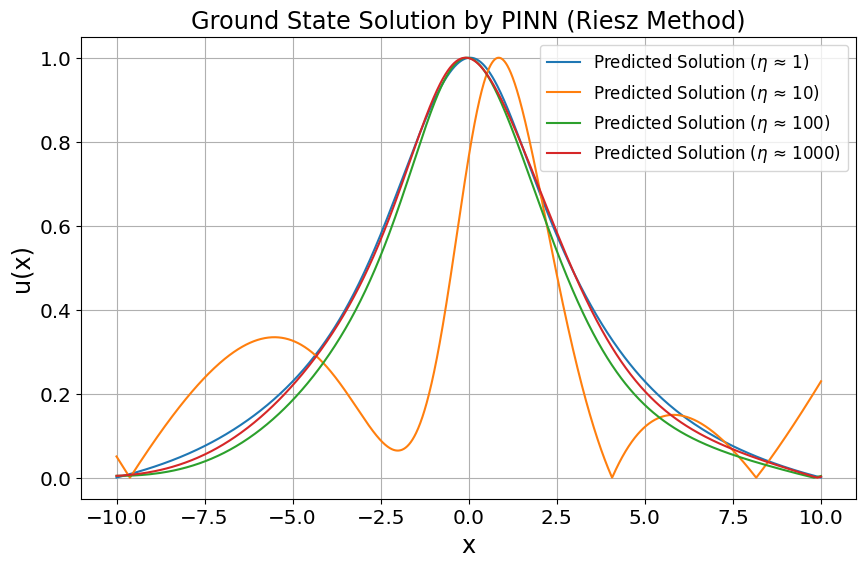

In [12]:
predict_and_plot(models, etas, X_test, save_path='plots/predicted_solutions.png')

# Plot the loss history for all etas

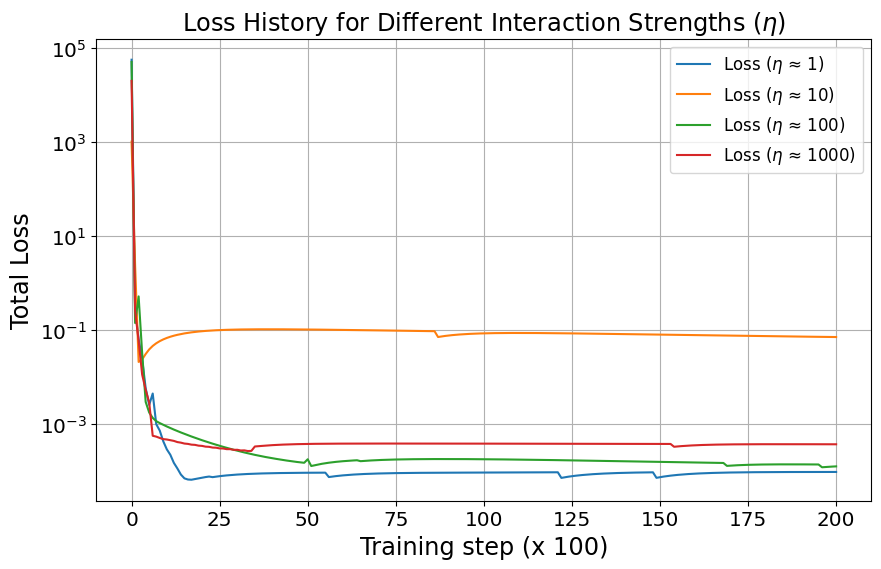

In [13]:
plot_loss_history(loss_histories, etas, save_path='plots/loss_history.png')